# Capítulo 8 – Detección de Anomalías con Autoencoders

En este capítulo se introduce el enfoque de **Autoencoders**, uno de los primeros modelos de **Deep Learning** aplicados a la detección de anomalías.  

Su principal fortaleza radica en que **aprenden una representación comprimida (codificación) de los datos normales y luego intentan reconstruirlos**.  
Cuando el modelo encuentra un dato anómalo —algo que no encaja en el patrón aprendido— el **error de reconstrucción** tiende a ser mayor, lo que permite identificar la anomalía.

## Motivación

La elección de Autoencoders responde a varias razones:

- Modelan **relaciones no lineales complejas** en los datos.  
- No requieren etiquetas, únicamente muestras representativas del comportamiento normal.  
- Permiten incorporar **estructuras temporales** (ventanas deslizantes o variantes recurrentes).  
- Funcionan como paso previo a arquitecturas más avanzadas, como los **LSTM Autoencoders**.  
- Representan una primera aproximación a las capacidades del **Deep Learning** en el campo de la detección de anomalías.

## Objetivo del capítulo

Este capítulo abordará:

- Los fundamentos teóricos de los Autoencoders y su uso en detección de anomalías.  
- La construcción de un modelo base entrenado sobre datos sintéticos y datos reales en formato MDF.  
- El análisis del **error de reconstrucción** como score de anomalía.  
- La comparación cualitativa con los modelos clásicos (PCA, Isolation Forest, One-Class SVM).  

Finalmente, se discutirán las principales variantes de Autoencoders y se introducirá su extensión hacia arquitecturas recurrentes.

## Intuición

El Autoencoder es una red neuronal formada por dos componentes:

- **Encoder**: reduce la dimensionalidad de los datos, generando una representación latente.  
- **Decoder**: reconstruye los datos originales a partir de dicha representación.  

De forma intuitiva:

> Un Autoencoder aprende a copiar los datos normales. Cuando recibe un patrón desconocido o anómalo, no consigue reconstruirlo con precisión y el error de reconstrucción se incrementa.

## Fundamento teórico

El entrenamiento de un Autoencoder se plantea como la minimización del error de reconstrucción:

$$
\min_{\theta} L(x, g_{\theta}(f_{\theta}(x)))
$$

donde:

- $f_{\theta}(x)$: función de codificación (encoder).  
- $g_{\theta}(z)$: función de decodificación (decoder).  
- $L(\cdot)$: función de pérdida, habitualmente el **MSE** (Mean Squared Error).  

El score de anomalía para un punto $x$ se define como:

$$
s(x) = \|x - \hat{x}\|^2
$$

Si $s(x)$ supera un umbral definido, el punto se clasifica como anómalo.

## Función de decisión y scores

- **Salida del modelo**: reconstrucción $\hat{x}$ de la entrada $x$.  
- **Score de anomalía**: error de reconstrucción.  
  - Valores bajos → dato normal.  
  - Valores altos → potencial anomalía.

## Parámetros clave

- Dimensión del espacio latente.  
- Número de capas y neuronas en la red.  
- Funciones de activación (ReLU, tanh, etc.).  
- Función de pérdida (MSE, MAE o variantes robustas).  
- Regularización (dropout, weight decay, sparsity).  

## Ventajas

- Capturan dependencias no lineales en los datos.  
- Escalan adecuadamente a problemas de alta dimensionalidad.  
- Pueden adaptarse a grandes volúmenes de datos.  
- Flexibles: existen variantes recurrentes y convolucionales.  

## Limitaciones

- Elevado coste computacional y de entrenamiento en comparación con modelos clásicos.  
- Requieren un ajuste cuidadoso de la arquitectura y del proceso de optimización.  
- Riesgo de sobreajuste si se entrenan durante demasiado tiempo o con datos ruidosos.  
- El umbral de anomalías debe definirse de forma adecuada para cada caso.  

## Ejemplo

Consideremos la monitorización de las **vibraciones de un motor** a través de tres sensores.  

En condiciones normales, las señales están correlacionadas entre sí. Si el motor empieza a vibrar de forma irregular en uno de los ejes, el Autoencoder —entrenado para reconstruir patrones normales— no podrá reproducir esa señal anómala con fidelidad.  

El error de reconstrucción crecerá significativamente en ese punto, lo que permitirá marcar la observación como anomalía.

## Referencias

- Sakurada, Mayu, and Takehisa Yairi.  
  *Anomaly detection using autoencoders with nonlinear dimensionality reduction.* MLSDA, 2014.   

- Bui, H., et al.  
  *Predicting sector configuration transitions with autoencoder-based anomaly detection.* ICRAT, 2018.

- GitHub – thomasdubdub.  
  *Autoencoder Anomaly Detection.* Disponible en: [https://github.com/thomasdubdub/autoencoder-anomaly-detection](https://github.com/thomasdubdub/autoencoder-anomaly-detection)  
  

## Validación experimental de Autoencoder

En este apartado se describe el procedimiento de validación aplicado al modelo **Autoencoder** para la detección de anomalías en series temporales. El objetivo es establecer un marco riguroso que garantice la comparabilidad con el resto de modelos evaluados.

El protocolo seguido consta de los siguientes pasos:

1. **Generación y partición de datos**: se emplea un conjunto sintético de series temporales con anomalías inyectadas, dividido en subconjuntos de entrenamiento (*train*), validación (*val*) y prueba (*test*). Los conjuntos *train* y *val* se combinan para la búsqueda de hiperparámetros, reservando *test* exclusivamente para la evaluación final.

2. **Esquema de validación walkforward**: dado que el entrenamiento del autoencoder se realiza de manera incremental, se utiliza un procedimiento de validación **walkforward**. En este enfoque, el modelo se entrena inicialmente con un bloque de datos y se reentrena progresivamente a medida que se incorporan nuevos bloques, preservando la causalidad temporal.

3. **Preprocesado de datos**: sobre cada bloque se aplica el mismo pipeline definido para los demás modelos, que incluye:
   - Filtro de Hampel aplicado a los residuos estacionales.
   - Estimación automática de la periodicidad estacional cuando procede.
   - Normalización mediante *StandardScaler* para estabilizar el entrenamiento de la red.

4. **Búsqueda de hiperparámetros**: se realiza un *grid search* sobre diferentes configuraciones de:
   - Dimensión del espacio latente (`latent_dim`).
   - Tasa de aprendizaje (`lr`).
   - Número de épocas de entrenamiento por bloque (`epochs`).
   - Tamaño de lote (`batch_size`).

5. **Métricas de validación**: en cada ventana del esquema walkforward se calculan las métricas **precision**, **recall**, **F1**, **ROC-AUC**, **NAB** y **window coverage**. Posteriormente, se seleccionan las cinco mejores configuraciones atendiendo al valor promedio de NAB.

6. **Evaluación final en test**: las configuraciones seleccionadas se reentrenan con *train+val* y se evalúan en *test*, generando tanto curvas ROC como gráficas comparativas entre anomalías reales y anomalías detectadas.

Este procedimiento asegura una validación coherente con la naturaleza incremental del modelo y permite contrastar su rendimiento con el resto de técnicas estudiadas.


Evaluación en test:   0%|          | 0/5 [00:00<?, ?it/s]

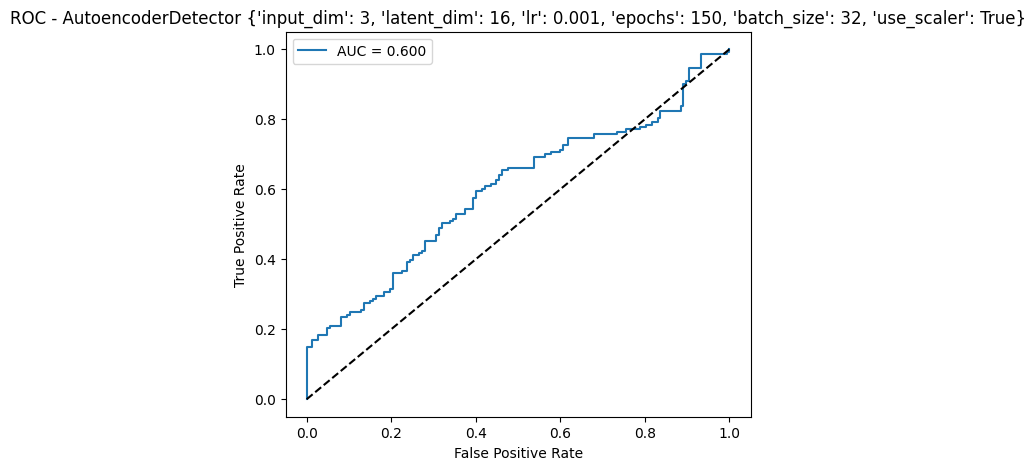

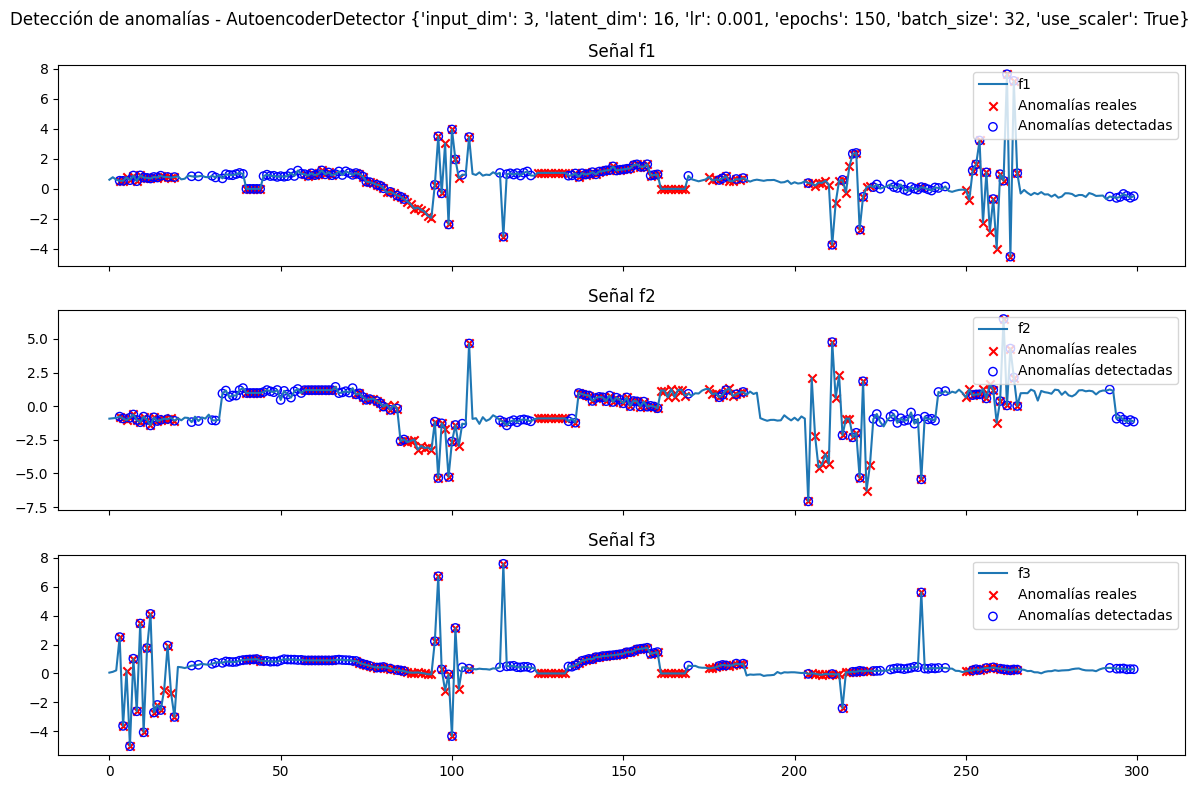

Evaluación en test:  20%|██        | 1/5 [00:05<00:20,  5.08s/it]

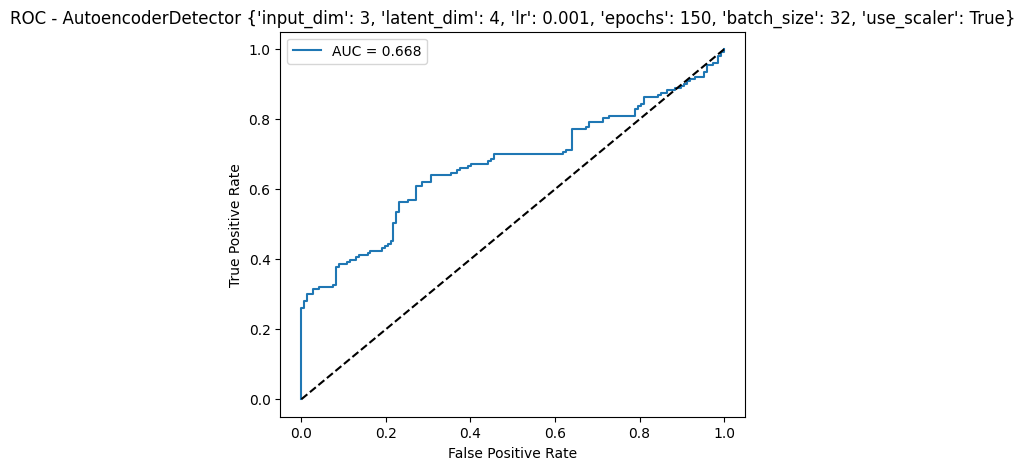

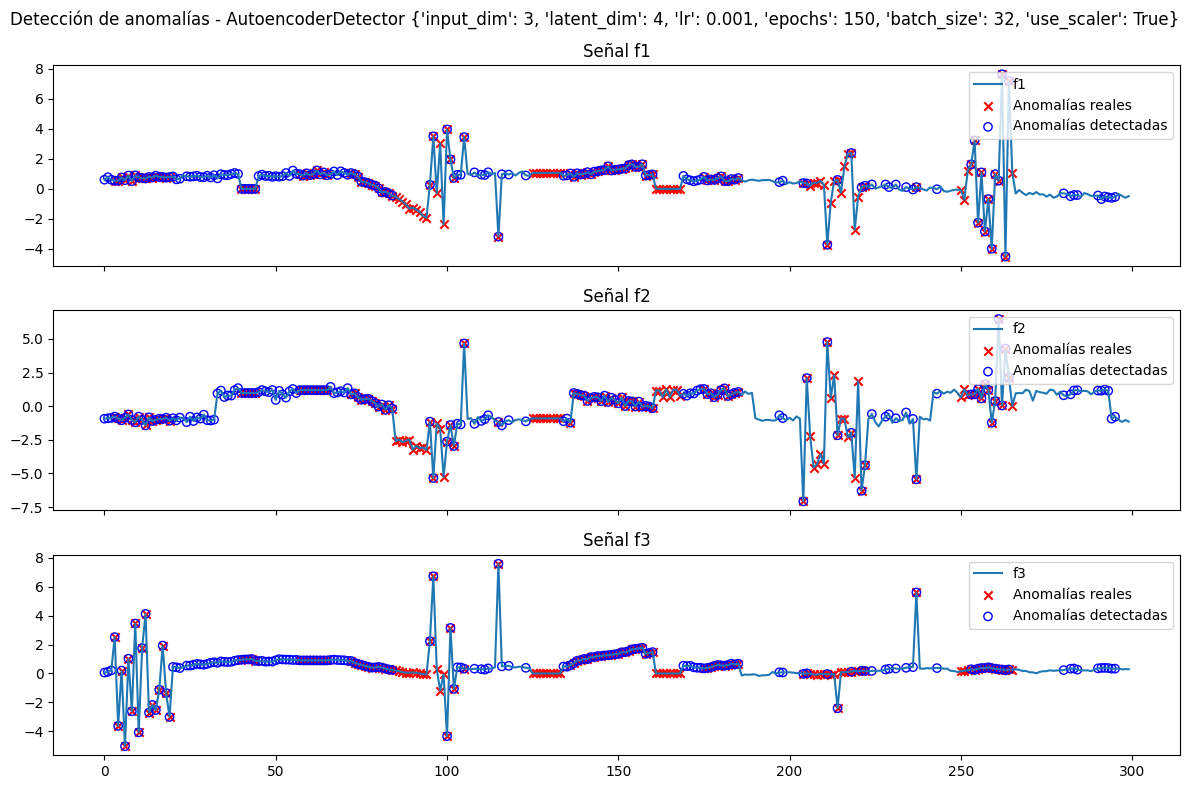

Evaluación en test:  40%|████      | 2/5 [00:09<00:14,  4.81s/it]

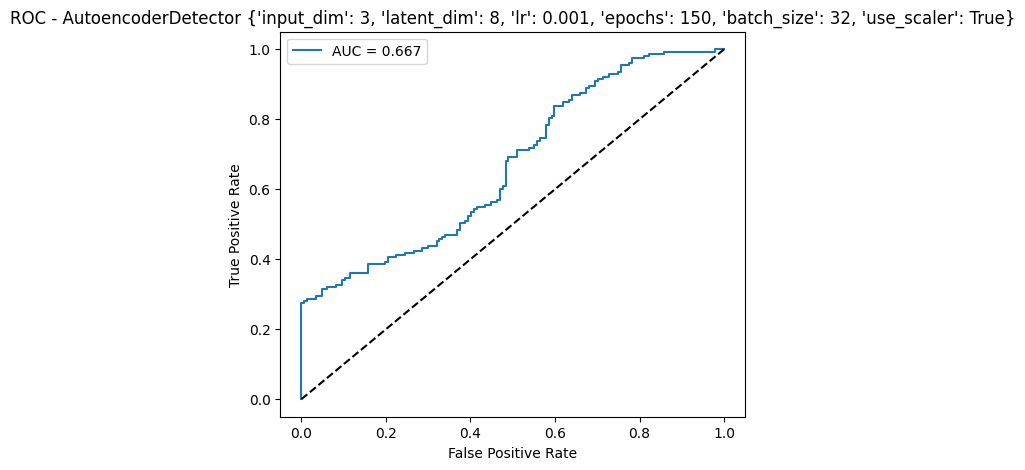

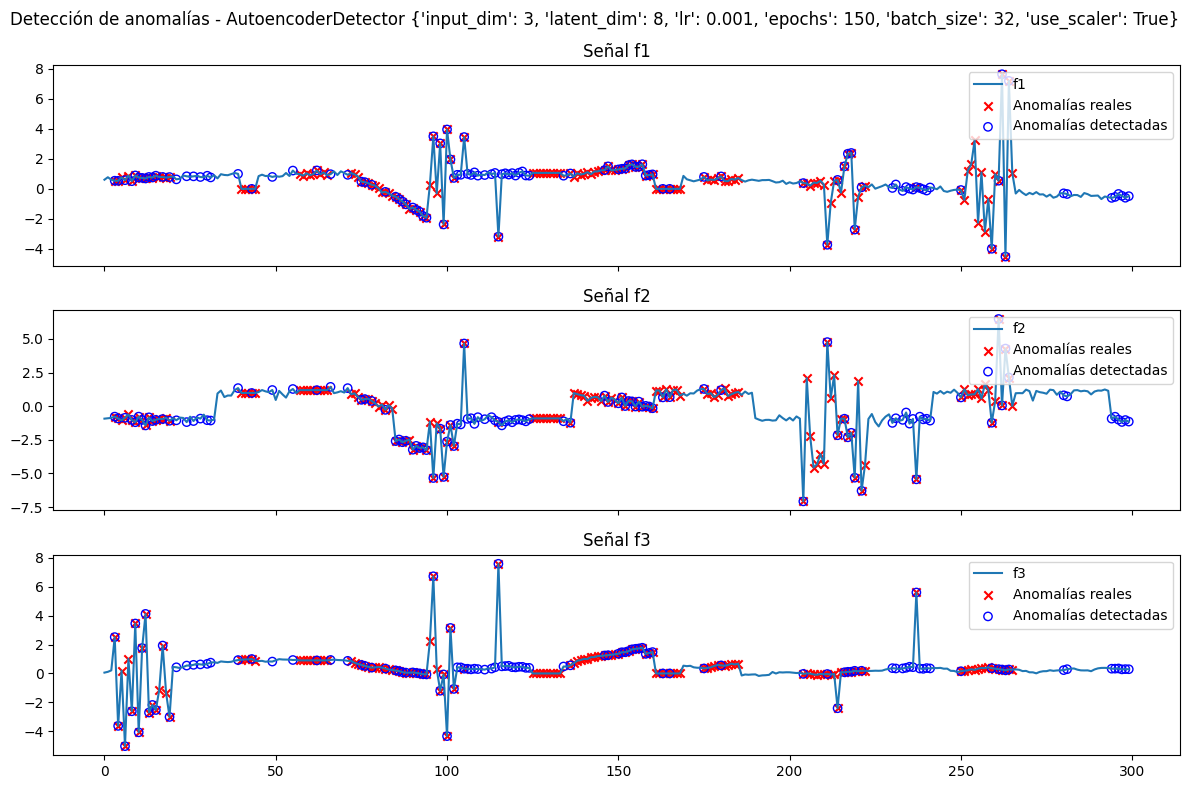

Evaluación en test:  60%|██████    | 3/5 [00:14<00:09,  4.74s/it]

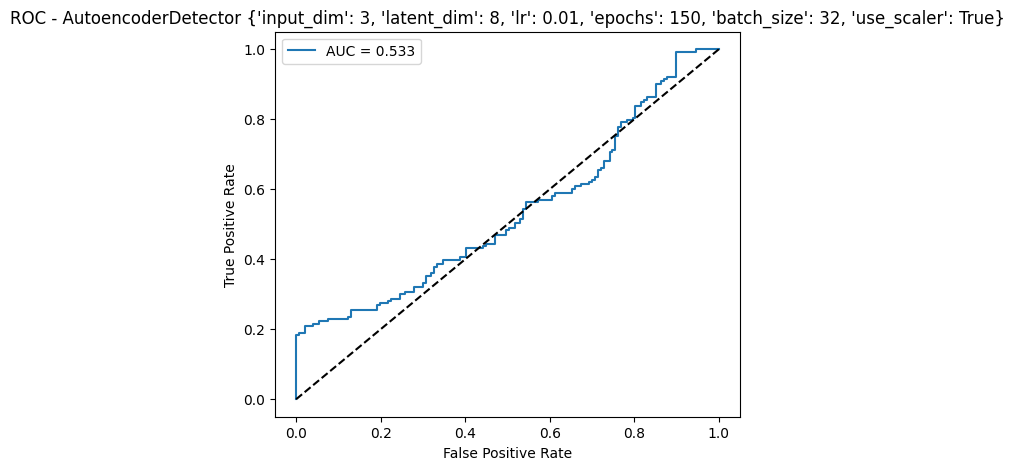

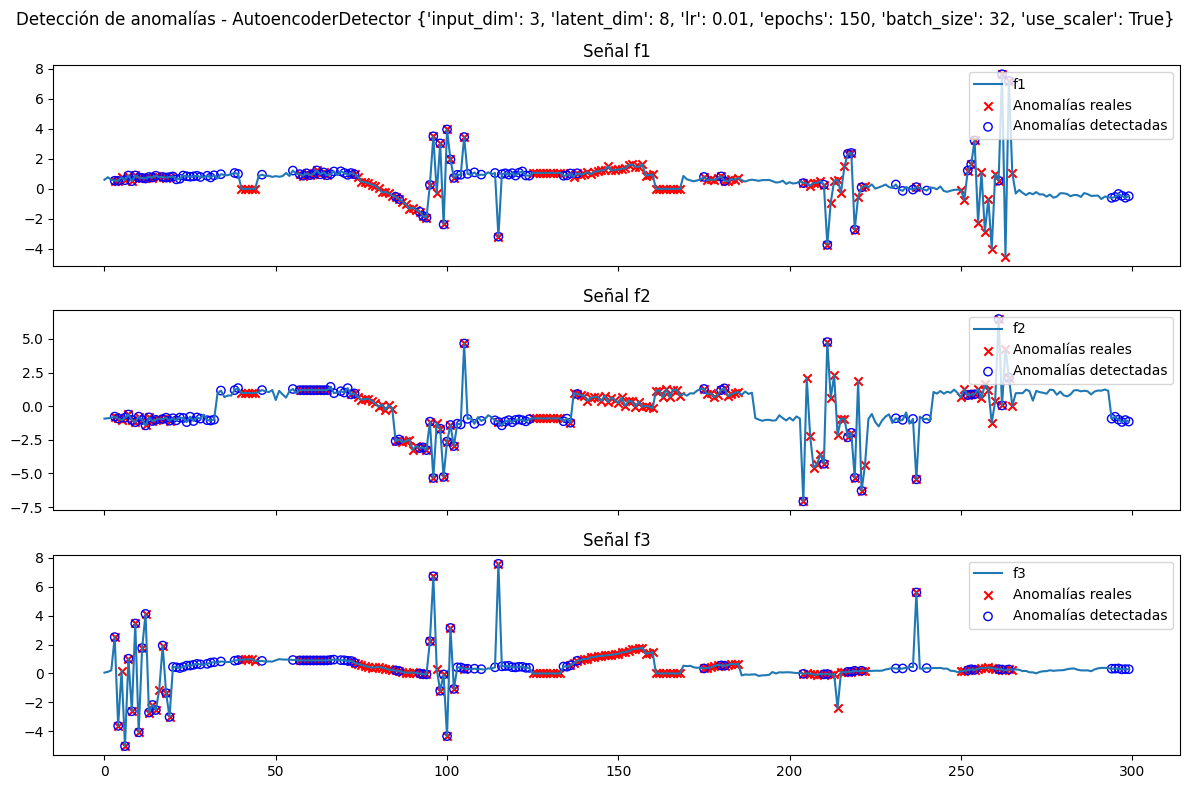

Evaluación en test:  80%|████████  | 4/5 [00:19<00:04,  4.71s/it]

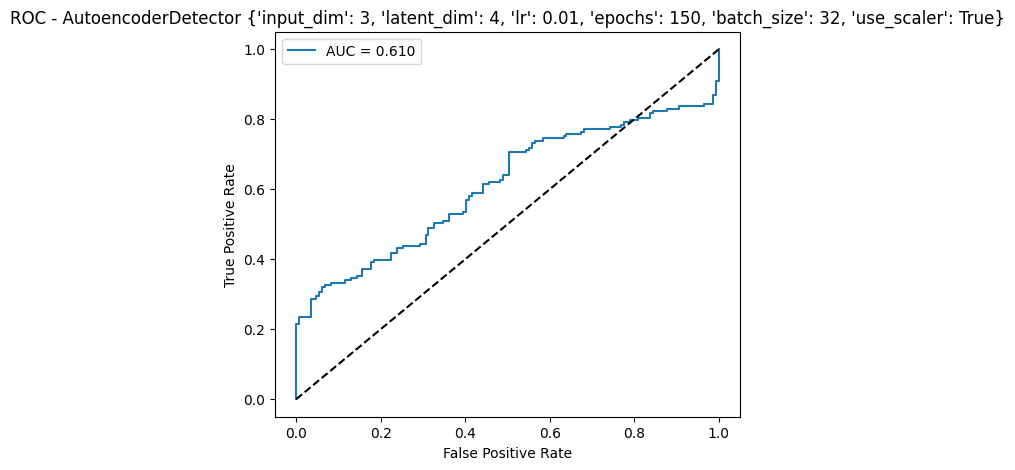

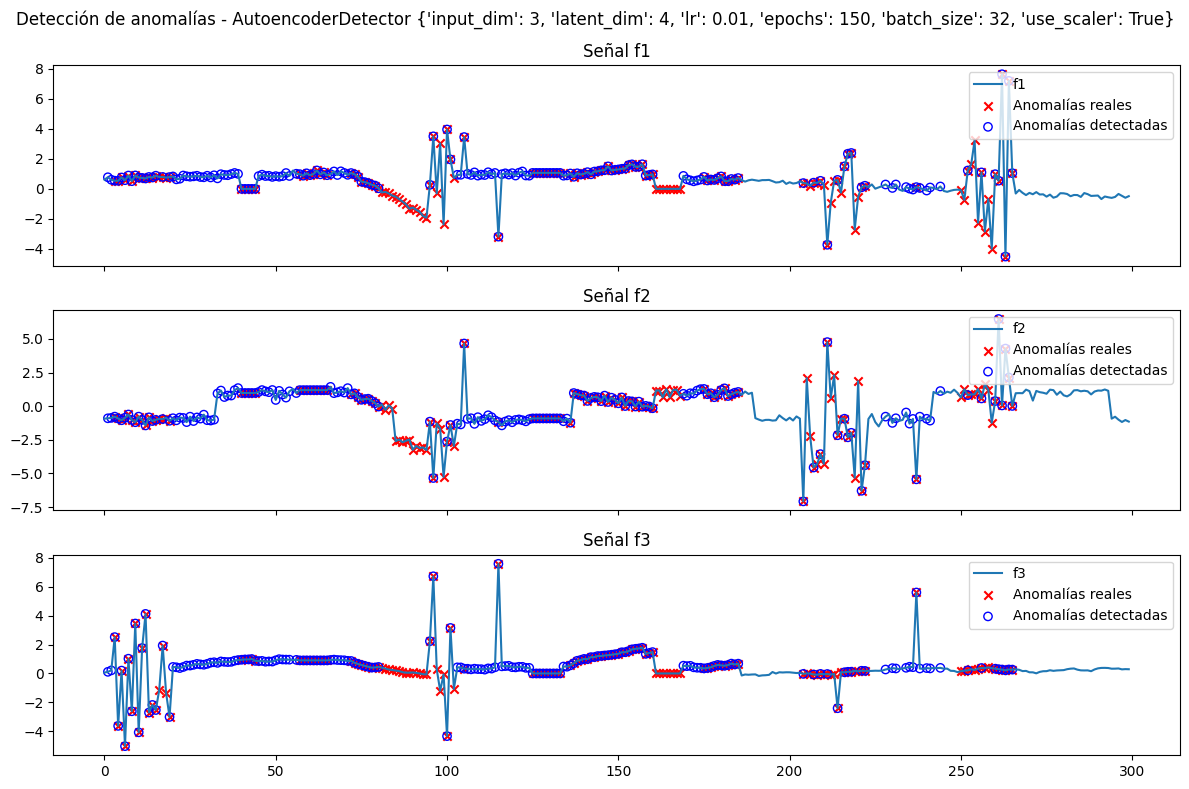

Evaluación en test: 100%|██████████| 5/5 [00:23<00:00,  4.74s/it]

Resultados de validación (grid search en train+val):


,precision,recall,f1,roc_auc,nab,window_cov,input_dim,latent_dim,lr,epochs,batch_size,use_scaler
0,0.635,0.606,0.578,0.831,0.638,0.534,3,4,0.010,30,32,True
1,0.560,0.629,0.540,0.898,0.745,0.555,3,4,0.001,30,32,True
2,0.526,0.682,0.556,0.854,0.658,0.592,3,8,0.010,30,32,True
3,0.576,0.632,0.546,0.856,0.721,0.597,3,8,0.001,30,32,True
4,0.487,0.599,0.417,0.844,0.609,0.566,3,16,0.010,30,32,True
5,0.558,0.704,0.594,0.903,0.760,0.619,3,16,0.001,30,32,True


Top 5 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_cov,input_dim,latent_dim,lr,epochs,batch_size,use_scaler
5,0.558,0.704,0.594,0.903,0.760,0.619,3,16,0.001,30,32,True
1,0.560,0.629,0.540,0.898,0.745,0.555,3,4,0.001,30,32,True
3,0.576,0.632,0.546,0.856,0.721,0.597,3,8,0.001,30,32,True
2,0.526,0.682,0.556,0.854,0.658,0.592,3,8,0.010,30,32,True
0,0.635,0.606,0.578,0.831,0.638,0.534,3,4,0.010,30,32,True


Resultados finales en TEST (top-5 configs):


,precision,recall,f1,roc_auc,nab,window_cov,input_dim,latent_dim,lr,epochs,batch_size,use_scaler
0,0.591,0.634,0.612,0.600,0.897,0.723,3,16,0.001,150,32,True
1,0.585,0.699,0.637,0.668,0.860,0.788,3,4,0.001,150,32,True
2,0.590,0.451,0.511,0.667,0.923,0.513,3,8,0.001,150,32,True
3,0.546,0.386,0.452,0.533,0.918,0.534,3,8,0.010,150,32,True
4,0.584,0.706,0.639,0.610,0.917,0.840,3,4,0.010,150,32,True


In [1]:
# ==========================
# 0. Imports
# ==========================
import pandas as pd
from utils import generate_synthetic_timeseries
from modelos.AutoencoderDetector import AutoencoderDetector
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_experiment

# ==========================
# 1. Generar datos sintéticos
# ==========================
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)

df_trainval = pd.concat([df_train, df_val], ignore_index=True)
X_trainval, y_trainval = df_trainval[["f1", "f2", "f3"]], df_trainval["anomaly"]
X_test, y_test = df_test[["f1", "f2", "f3"]], df_test["anomaly"]

# ==========================
# 2. Definir métricas
# ==========================
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

# ==========================
# 3. Definir grid de hiperparámetros
# ==========================
param_grid_ae = {
    "input_dim": [3],                 # nº de features
    "latent_dim": [4, 8, 16],      # exploramos más compresión
    "lr": [1e-2, 1e-3],   # tasas de aprendizaje desde rápidas a conservadoras
    "epochs": [30],           # número de épocas por bloque
    "batch_size": [32],       # tamaños de lote más pequeños y más grandes
    "use_scaler": [True],             # mantenemos normalización
}

# ==========================
# 4. Ejecutar experimento con walkforward
# ==========================
df_results, top5, df_final = run_experiment(
    model_class=AutoencoderDetector,
    param_grid=param_grid_ae,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    X_test=X_test,
    y_test=y_test,
    metrics=metrics,
    params_cv={"P_train": 0.4, "num_windows": 5},  
    mode="walkforward",                            
    sort_metric="nab",
    top_k=5,
    plot_results=True,
    df_test=df_test
)


# Conclusiones de la validación – Autoencoder

Los experimentos realizados con el Autoencoder permiten evaluar por primera vez un enfoque basado en deep learning dentro del pipeline de detección de anomalías.  
Los resultados muestran un perfil particular: gran capacidad de reconstrucción, pero con un sesgo hacia la detección conservadora.


## Observaciones clave

1. Espacio latente y estabilidad  
   - Los modelos con latent_dim=8 y 16 ofrecen el mejor balance entre precisión y recall.  
   - Latentes demasiado pequeños reducen la capacidad de reconstrucción y afectan a las métricas de cobertura.  

2. Efecto del learning rate  
   - Un learning rate bajo (0.001) resulta más estable y consistente en validación.  
   - Con valores más altos (0.01) se observan configuraciones competitivas, pero también mayor variabilidad entre ventanas.  

3. Patrón de test  
   - En el conjunto de test, algunos modelos alcanzan precisiones extremadamente altas (0.92–1.00), pero a costa de un recall muy reducido.  
   - Este comportamiento refleja un detector conservador, que solo marca como anomalía los casos más evidentes.  
   - Configuraciones con latent_dim=16 logran un mejor equilibrio y destacan en NAB.  

4. Métricas compuestas  
   - De forma consistente con modelos anteriores, la NAB vuelve a ser la métrica más útil para seleccionar configuraciones prácticas, frente a métricas clásicas como precision o f1.  


## Comparación con modelos anteriores

- Frente a PCA:  
  El autoencoder supera al PCA en métricas como ROC-AUC y NAB, gracias a su capacidad para modelar relaciones no lineales.  

- Frente a One-Class SVM:  
  Ambos modelos tienden a ser conservadores, pero el autoencoder lo es aún más, logrando mayor precisión a costa de sacrificar recall.  

- Frente a Isolation Forest:  
  El Isolation Forest mostró un mejor balance sin necesidad de ajuste complejo.  
  El autoencoder, en cambio, requiere entrenamiento intensivo y es más sensible a la configuración, aunque logra resultados competitivos en NAB.  


## Conclusión

El Autoencoder constituye un avance importante al introducir arquitecturas neuronales en el pipeline.  
Se caracteriza por ser fiable pero conservador, con un rendimiento competitivo en NAB y gran precisión, aunque limitado en recall.  
Esto lo convierte en un modelo útil para escenarios donde es prioritario minimizar falsos positivos, aunque con el riesgo de pasar por alto anomalías más sutiles.


## Próximos pasos

En el siguiente capítulo se abordará el LSTM Autoencoder, que extiende este enfoque incorporando memoria temporal.  
A diferencia del autoencoder clásico, el LSTM podrá capturar dependencias secuenciales y anomalías que se manifiestan en varios pasos, lo que se espera incremente el recall y la cobertura de ventanas anómalas.
